In [1]:
import pandas as pd
import geopandas as gpd
import maup
import time
from maup import smart_repair
from gerrychain import Graph

maup.progress.enabled = True

In [2]:
import warnings
warnings.filterwarnings("ignore")

In [3]:
# state = West Virginia
state_ab = "wv"

## Data
1. Download all the data in directory "wv_data"
2. Extract them all

In [5]:
data_folder = state_ab + "_data/"
population1_data = "./{}{}_pl2020_b/{}_pl2020_p1_b.shp".format(data_folder, state_ab, state_ab)
population2_data = "./{}{}_pl2020_b/{}_pl2020_p2_b.shp".format(data_folder, state_ab, state_ab)
vap_data =  "./{}{}_pl2020_b/{}_pl2020_p4_b.shp".format(data_folder, state_ab, state_ab)
vest20_data = "./{}{}_vest_20/{}_vest_20.shp".format(data_folder, state_ab, state_ab)
vest18_data = "./{}{}_vest_18/{}_vest_18.shp".format(data_folder, state_ab, state_ab)
vest16_data = "./{}{}_vest_16/{}_vest_16.shp".format(data_folder, state_ab, state_ab)
cd_data = "./{}{}_cong_2021/consensus_congressional.shp".format(data_folder, state_ab)
send_data = "./{}{}_sldu_2021/SENfinal_shp.shp".format(data_folder, state_ab)
hdist_data = "./{}{}_sldl_2021/HODfinal_shp.shp".format(data_folder, state_ab)
county_data = "./{}{}_pl2020_cnty/{}_pl2020_cnty.shp".format(data_folder, state_ab, state_ab)

In [6]:
def do_smart_repair(df, min_rook_length = None, snap_precision = 10):
    # change it to the UTM it needs for smart_repair
    df = df.to_crs(df.estimate_utm_crs())
    df = smart_repair(df, min_rook_length = min_rook_length, snap_precision = snap_precision)

    if maup.doctor(df) == False:
        raise Exception('maup.doctor failed')
    
    return df

In [7]:
def add_district(dist_df, dist_name, election_df, col_name):
    election_df = election_df.to_crs(election_df.estimate_utm_crs())
    dist_df = dist_df.to_crs(dist_df.estimate_utm_crs())
    # check if it needs to be smart_repair
    if maup.doctor(dist_df) != True:
        dist_df = do_smart_repair(dist_df)

    # assign the pricincts
    precincts_to_district_assignment = maup.assign(election_df.geometry, dist_df.geometry)
    election_df[dist_name] = precincts_to_district_assignment
    for precinct_index in range(len(election_df)):
        election_df.at[precinct_index, dist_name] = dist_df.at[election_df.at[precinct_index, dist_name], col_name]

    return election_df

In [8]:
def rename(original, year):
    party = original[6]
    if party == 'R' or party == 'D':
        return original[3:6] + year + original[6]
    else:
        return original[3:6] + year + 'O'

In [9]:
pop_col = ['TOTPOP', 'HISP', 'NH_WHITE', 'NH_BLACK', 'NH_AMIN', 'NH_ASIAN', 'NH_NHPI', 'NH_OTHER', 'NH_2MORE', 'H_WHITE', 'H_BLACK', 'H_AMIN', 'H_ASIAN', 'H_NHPI', 'H_OTHER', 'H_2MORE', 'VAP', 'HVAP', 'WVAP', 'BVAP', 'AMINVAP', 'ASIANVAP', 'NHPIVAP', 'OTHERVAP', '2MOREVAP']

In [10]:
def check_population(population, df):
    pop_check = pd.DataFrame({
        'pop_col': pop_col,
        'population_df': population[pop_col].sum(), 
        'vest_base': df[pop_col].sum(),
        'equal': [x == y for x, y in zip(population[pop_col].sum(), df[pop_col].sum())]
    })
    if pop_check['equal'].mean() < 1:
        print(pop_check)
        raise Exception("population doesn't agree")

    else:
        print("population agrees")

In [11]:
def add_vest(vest, df, year, population, start_col, snap_precision = 10):
    df = df.to_crs(df.estimate_utm_crs())
    vest = vest.to_crs(vest.estimate_utm_crs())
    population = population.to_crs(population.estimate_utm_crs())
    df_crs = df.crs
    vest_crs = vest.crs
    
     # check if it needs to be smart_repair
    if maup.doctor(vest) != True:
        vest = do_smart_repair(vest, snap_precision = snap_precision)
    
    # rename the columns
    original_col = vest.columns[start_col:-1]
    new_col = [rename(i, year) for i in original_col]
    rename_dict = dict(zip(original_col, new_col))
    vest = vest.rename(columns=rename_dict)
    vest = vest.groupby(level=0, axis=1).sum() # combine all the other party's vote into columns with sufix "O"
    col_name = list(set(new_col))
    col_name.sort()
    
    # make the blocks from precincts by weight
    vest = gpd.GeoDataFrame(vest, crs=vest_crs)
    election_in_block = population[["VAP", 'geometry']] # population_df is in block scale
    blocks_to_precincts_assignment = maup.assign(election_in_block.geometry, vest.geometry)
    weights = election_in_block["VAP"] / blocks_to_precincts_assignment.map(election_in_block["VAP"].groupby(blocks_to_precincts_assignment).sum())
    weights = weights.fillna(0)
    prorated = maup.prorate(blocks_to_precincts_assignment, vest[col_name], weights)
    election_in_block[col_name] = prorated
    
    # assign blocks to precincts
    election_in_block = gpd.GeoDataFrame(election_in_block, crs=vest_crs)
    df = gpd.GeoDataFrame(df, crs=df_crs)
    block_to_pricinct_assginment = maup.assign(election_in_block.geometry, df.geometry)
    df[col_name] = election_in_block[col_name].groupby(block_to_pricinct_assginment).sum()
    df = df.groupby(level=0, axis=1).sum()
    df = gpd.GeoDataFrame(df, crs = df_crs)
    # check if population agrees
    check_population(population, df)
    
    return df

In [12]:
def add_vest_base(vest, start_col, year, county = None, min_rook_length = None, snap_precision = 10):
    vest = vest.to_crs(vest.estimate_utm_crs())
    vest_crs = vest.crs
    original_col = vest.columns[start_col:-1]
    new_col = [rename(i, year) for i in original_col]
    rename_dict = dict(zip(original_col, new_col))
    vest = vest.rename(columns=rename_dict)
    vest = vest.groupby(level=0, axis=1).sum()
    vest = gpd.GeoDataFrame(vest, crs=vest_crs)

    if county is not None:
        county = county.to_crs(county.estimate_utm_crs())
        vest = smart_repair(vest, nest_within_regions = county, min_rook_length = min_rook_length, snap_precision = snap_precision) # nest precincts within counties

    else:
        vest = smart_repair(vest, min_rook_length = min_rook_length, snap_precision = snap_precision) 
    
    return vest

In [13]:
def check_small_boundary_lengths(vest_base):
    import copy
    vest_base = vest_base.to_crs(vest_base.estimate_utm_crs())

    boundaries = copy.deepcopy(vest_base)
    boundaries["geometry"] = boundaries.geometry.boundary  # get boundaries
    neighbors = gpd.sjoin(boundaries, vest_base, predicate="intersects") # find boundaries that intersect
    neighbors = neighbors[neighbors.index != neighbors.index_right] # remove boundaries of a region with itself

    # compute shared border length using intersection
    borders = list(neighbors.apply(
        lambda row: row.geometry.intersection(vest_base.loc[row.index_right, "geometry"]).length, axis=1
    ))

    borders.sort()
    
    return borders

### Read the census data

In [15]:
population1_df = gpd.read_file(population1_data)
population2_df = gpd.read_file(population2_data)
vap_df = gpd.read_file(vap_data)
county_df = gpd.read_file(county_data)

In [16]:
population2_df = population2_df.drop(columns=['SUMLEV', 'LOGRECNO', 'GEOID', 'COUNTY', 'geometry'])
vap_df = vap_df.drop(columns=['SUMLEV', 'LOGRECNO', 'GEOID', 'COUNTY', 'geometry'])

In [17]:
population_df = pd.merge(population1_df, population2_df, on='GEOID20')
population_df = pd.merge(population_df, vap_df, on='GEOID20')
population_df = population_df.to_crs(population_df.estimate_utm_crs())

In [18]:
maup.doctor(population_df)

100%|███████████████████████████████████| 72558/72558 [00:35<00:00, 2048.19it/s]


True

In [19]:
population_df['H_WHITE'] = population_df.apply(lambda t: t['P0010003'] - t['P0020005'], 1)
population_df['H_BLACK'] = population_df.apply(lambda t: t['P0010004'] - t['P0020006'], 1)
population_df['H_AMIN'] = population_df.apply(lambda t: t['P0010005'] - t['P0020007'], 1)
population_df['H_ASIAN'] = population_df.apply(lambda t: t['P0010006'] - t['P0020008'], 1)
population_df['H_NHPI'] = population_df.apply(lambda t: t['P0010007'] - t['P0020009'], 1)
population_df['H_OTHER'] = population_df.apply(lambda t: t['P0010008'] - t['P0020010'], 1)
population_df['H_2MORE'] = population_df.apply(lambda t: t['P0010009'] - t['P0020011'], 1)

In [20]:
rename_dict = {'P0020001': 'TOTPOP', 'P0020002': 'HISP', 'P0020005': 'NH_WHITE', 'P0020006': 'NH_BLACK', 'P0020007': 'NH_AMIN',
                    'P0020008': 'NH_ASIAN', 'P0020009': 'NH_NHPI', 'P0020010': 'NH_OTHER', 'P0020011': 'NH_2MORE',
                    'P0040001': 'VAP', 'P0040002': 'HVAP', 'P0040005': 'WVAP', 'P0040006': 'BVAP', 'P0040007': 'AMINVAP',
                                        'P0040008': 'ASIANVAP', 'P0040009': 'NHPIVAP', 'P0040010': 'OTHERVAP', 'P0040011': '2MOREVAP'}

In [21]:
population_df.rename(columns=rename_dict, inplace = True)

In [22]:
county_df = county_df.to_crs(county_df.estimate_utm_crs())
maup.doctor(county_df)

100%|██████████████████████████████████████████| 55/55 [00:00<00:00, 335.73it/s]


True

## Read the vest 20 data

Now using it as a "base pricinct"

## Check if vest20 can be used as base

In [25]:
vest20 = gpd.read_file(vest20_data)

In [26]:
vest20.columns

Index(['STATEFP', 'COUNTYFP', 'VTDST', 'NAME', 'NAMELSAD', 'G20PRERTRU',
       'G20PREDBID', 'G20PRELJOR', 'G20PREMHAW', 'G20USSRCAP', 'G20USSDSWE',
       'G20USSLMOR', 'G20GOVRJUS', 'G20GOVDSAL', 'G20GOVLKOL', 'G20GOVMLUT',
       'G20SOSRWAR', 'G20SOSDTEN', 'G20AUDRMCC', 'G20AUDDCLA', 'G20TRERMOO',
       'G20TREDPER', 'G20AGRRLEO', 'G20AGRDBEA', 'G20ATGRMOR', 'G20ATGDPET',
       'geometry'],
      dtype='object')

In [27]:
start_col = 5
vest_base_data = vest20
year = '20'

In [28]:
vest_base = add_vest_base(vest_base_data, start_col, year, county = county_df)

100%|██████████████████████████████████████████| 55/55 [00:00<00:00, 343.74it/s]


Snapping all geometries to a grid with precision 10^( -5 ) to avoid GEOS errors.


100%|███████████████████████████████████████████| 55/55 [00:00<00:00, 91.86it/s]


Identifying overlaps...


100%|█████████████████████████████████████| 8346/8346 [00:04<00:00, 2024.21it/s]


Resolving overlaps and filling gaps...


Gaps to simplify in region 0: 100%|█████████████| 67/67 [00:00<00:00, 95.65it/s]
Gaps to fill: 0it [00:00, ?it/s]
Gaps to simplify in region 3: 100%|███████████████| 3/3 [00:00<00:00, 80.64it/s]
Gaps to fill: 0it [00:00, ?it/s]
Gaps to simplify in region 4: 100%|██████████████| 7/7 [00:00<00:00, 121.68it/s]
Gaps to fill: 0it [00:00, ?it/s]
Gaps to simplify in region 5: 100%|████████████| 58/58 [00:00<00:00, 114.39it/s]
Gaps to fill: 0it [00:00, ?it/s]
Gaps to simplify in region 6: 100%|█████████████| 43/43 [00:00<00:00, 89.85it/s]
Gaps to fill: 0it [00:00, ?it/s]
Gaps to simplify in region 9: 100%|█████████████| 74/74 [00:00<00:00, 75.46it/s]
Gaps to fill: 0it [00:00, ?it/s]
Gaps to simplify in region 12: 100%|████████████| 79/79 [00:01<00:00, 76.51it/s]
Gaps to fill: 0it [00:00, ?it/s]
Gaps to simplify in region 20: 100%|████████████| 33/33 [00:00<00:00, 95.51it/s]
Gaps to fill: 0it [00:00, ?it/s]
Gaps to simplify in region 23: 100%|████████████| 80/80 [00:00<00:00, 93.13it/s]
Gaps to

In [29]:
borders = check_small_boundary_lengths(vest_base)
print(borders[:500])

[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,

In [30]:
vest_base = do_smart_repair(vest_base, min_rook_length = 30.5)

Snapping all geometries to a grid with precision 10^( -5 ) to avoid GEOS errors.
Identifying overlaps...


100%|█████████████████████████████████████| 1810/1810 [00:00<00:00, 3706.35it/s]


Resolving overlaps...
Filling gaps...


Gaps to simplify: 0it [00:00, ?it/s]
Gaps to fill: 0it [00:00, ?it/s]


Converting small rook adjacencies to queen...


100%|██████████████████████████████████████| 1671/1671 [00:02<00:00, 732.31it/s]


In [31]:
maup.doctor(vest_base)

100%|██████████████████████████████████████| 1671/1671 [00:02<00:00, 750.88it/s]


True

In [32]:
# vap and population have the same GEOID20
blocks_to_precincts_assignment = maup.assign(population_df.geometry, vest_base.geometry)

100%|██████████████████████████████████████| 1671/1671 [00:09<00:00, 171.85it/s]


In [33]:
vest_base[pop_col] = population_df[pop_col].groupby(blocks_to_precincts_assignment).sum()

In [34]:
election_df = gpd.GeoDataFrame(vest_base)

In [35]:
election_df.columns

Index(['AGR20D', 'AGR20R', 'ATG20D', 'ATG20R', 'AUD20D', 'AUD20R', 'COUNTYFP',
       'GOV20D', 'GOV20O', 'GOV20R', 'NAME', 'NAMELSAD', 'PRE20D', 'PRE20O',
       'PRE20R', 'SOS20D', 'SOS20R', 'STATEFP', 'TRE20D', 'TRE20R', 'USS20D',
       'USS20O', 'USS20R', 'VTDST', 'geometry', 'TOTPOP', 'HISP', 'NH_WHITE',
       'NH_BLACK', 'NH_AMIN', 'NH_ASIAN', 'NH_NHPI', 'NH_OTHER', 'NH_2MORE',
       'H_WHITE', 'H_BLACK', 'H_AMIN', 'H_ASIAN', 'H_NHPI', 'H_OTHER',
       'H_2MORE', 'VAP', 'HVAP', 'WVAP', 'BVAP', 'AMINVAP', 'ASIANVAP',
       'NHPIVAP', 'OTHERVAP', '2MOREVAP'],
      dtype='object')

## Check if population agrees

In [37]:
check_population(population_df, vest_base)

population agrees


## Add more vest data

In [39]:
vest18 = gpd.read_file(vest18_data)
vest16 = gpd.read_file(vest16_data)

In [40]:
vest18.columns

Index(['STATEFP', 'COUNTYFP', 'VTDST', 'NAME', 'NAMELSAD', 'G18USSRMOR',
       'G18USSDMAN', 'G18USSLHOL', 'geometry'],
      dtype='object')

In [41]:
vest16.columns

Index(['STATEFP', 'COUNTYFP', 'VTDST', 'NAME', 'NAMELSAD', 'G16PRERTRU',
       'G16PREDCLI', 'G16PRELJOH', 'G16PREMSTE', 'G16PRECCAS', 'G16GOVRCOL',
       'G16GOVDJUS', 'G16GOVLMOR', 'G16GOVMPRI', 'G16GOVCHUD', 'G16SOSRWAR',
       'G16SOSDTEN', 'G16SOSLBUC', 'G16AUDRMCC', 'G16AUDDCLA', 'G16AUDLRIC',
       'G16TRERURL', 'G16TREDPER', 'G16TRELYOU', 'G16AGRRLEO', 'G16AGRDHEL',
       'G16AGRLGUT', 'G16ATGRMOR', 'G16ATGDREY', 'G16ATGLKOL', 'G16ATGMSHA',
       'geometry'],
      dtype='object')

In [42]:
# check the result here
election_df = add_vest(vest18, election_df, '18', population_df, start_col)

100%|██████████████████████████████████████| 1704/1704 [00:02<00:00, 710.42it/s]


There are 19 overlaps.
Snapping all geometries to a grid with precision 10^( -5 ) to avoid GEOS errors.
Identifying overlaps...


100%|█████████████████████████████████████| 1862/1862 [00:00<00:00, 3634.06it/s]


Resolving overlaps...
Assigning order 2 pieces...
Filling gaps...


Gaps to simplify: 0it [00:00, ?it/s]
Gaps to fill: 0it [00:00, ?it/s]
100%|██████████████████████████████████████| 1671/1671 [00:09<00:00, 170.95it/s]


population agrees


In [43]:
election_df.columns

Index(['2MOREVAP', 'AGR20D', 'AGR20R', 'AMINVAP', 'ASIANVAP', 'ATG20D',
       'ATG20R', 'AUD20D', 'AUD20R', 'BVAP', 'COUNTYFP', 'GOV20D', 'GOV20O',
       'GOV20R', 'HISP', 'HVAP', 'H_2MORE', 'H_AMIN', 'H_ASIAN', 'H_BLACK',
       'H_NHPI', 'H_OTHER', 'H_WHITE', 'NAME', 'NAMELSAD', 'NHPIVAP',
       'NH_2MORE', 'NH_AMIN', 'NH_ASIAN', 'NH_BLACK', 'NH_NHPI', 'NH_OTHER',
       'NH_WHITE', 'OTHERVAP', 'PRE20D', 'PRE20O', 'PRE20R', 'SOS20D',
       'SOS20R', 'STATEFP', 'TOTPOP', 'TRE20D', 'TRE20R', 'USS18D', 'USS18O',
       'USS18R', 'USS20D', 'USS20O', 'USS20R', 'VAP', 'VTDST', 'WVAP',
       'geometry'],
      dtype='object')

In [44]:
election_df = add_vest(vest16, election_df, '16', population_df, start_col)

100%|██████████████████████████████████████| 1721/1721 [00:02<00:00, 727.84it/s]


There are 20 overlaps.
Snapping all geometries to a grid with precision 10^( -5 ) to avoid GEOS errors.
Identifying overlaps...


100%|█████████████████████████████████████| 1876/1876 [00:00<00:00, 3631.32it/s]


Resolving overlaps...
Assigning order 2 pieces...
Filling gaps...


Gaps to simplify: 0it [00:00, ?it/s]
Gaps to fill: 0it [00:00, ?it/s]
100%|██████████████████████████████████████| 1671/1671 [00:09<00:00, 169.00it/s]


population agrees


##  Add the district data

In [47]:
cong_df = gpd.read_file(cd_data)
cong_df = cong_df.to_crs(cong_df.estimate_utm_crs())
send = gpd.read_file(send_data)
send = send.to_crs(send.estimate_utm_crs())
hdist = gpd.read_file(hdist_data)
hdist = hdist.to_crs(hdist.estimate_utm_crs())

In [48]:
cong_df.head()

,ID,AREA,DISTRICT,MEMBERS,LOCKED,NAME,POPULATION,F18_POP,IDEAL_VALU,DEVIATION,F_DEVIATIO,F_18_POP,MULTIPLE_F,DISTRICT_L,geometry
0,2,9771.11621,2,1.0,None,None,897649,717250,896858.0,791.0,0.000882,0.799032,2|0.09%|897649|791,2|0.09%,"POLYGON ((489544.391 4367585.415, 489656.513 4..."
1,9,14440.57320,1,1.0,None,None,896067,715682,896858.0,-791.0,-0.000882,0.798693,1|-0.09%|896067|-791,1|-0.09%,"POLYGON ((562055.344 4171851.658, 562056.589 4..."


In [49]:
election_df = add_district(cong_df, "CD", election_df, "DISTRICT")

100%|█████████████████████████████████████████████| 2/2 [00:00<00:00,  6.86it/s]


In [52]:
send.head()

,ID,AREA,DISTRICT,MEMBERS,LOCKED,NAME,POPULATION,IDEAL_VALU,DEVIATION,F_DEVIATIO,MULTIPLE_F,DISTRICT_L,geometry
0,1,499.417725,1,1.0,None,None,102975,105513.0,-2538.0,-0.024054,1|-2.41%|102975,1|-2.41%,"POLYGON ((523044.904 4396861.766, 523043.524 4..."
1,2,3092.952140,10,1.0,None,None,107707,105513.0,2194.0,0.020794,10|2.08%|107707,10|2.08%,"POLYGON ((479753.680 4235100.839, 479755.695 4..."
2,3,4446.639640,11,1.0,None,None,102050,105513.0,-3463.0,-0.032821,11|-3.28%|102050,11|-3.28%,"POLYGON ((497244.255 4279917.847, 497507.440 4..."
3,4,1519.752930,12,1.0,None,None,104886,105513.0,-627.0,-0.005942,12|-0.59%|104886,12|-0.59%,"POLYGON ((475862.933 4307366.190, 475949.617 4..."
4,5,209.077103,13,1.0,None,None,110029,105513.0,4516.0,0.042800,13|4.28%|110029,13|4.28%,"POLYGON ((586528.338 4376914.774, 586552.532 4..."


In [53]:
election_df = add_district(send, "SEND", election_df, "DISTRICT")

100%|███████████████████████████████████████████| 17/17 [00:00<00:00, 21.88it/s]


In [55]:
hdist.head()

,ID,AREA,DISTRICT,MEMBERS,LOCKED,NAME,POPULATION,WHITE,AP_BLK,AP_IND,...,F_AP_BLK,F_AP_IND,F_AP_ASN,F_AP_HWN,F_AP_OTH,F_2_RACES,F_HISPANIC,F_18_POP,DISTRICT_L,geometry
0,1,87.084351,1,1.0,None,None,18807,17676,274,304,...,0.014569,0.016164,0.007550,0.000904,0.022970,0.043388,0.012389,0.821503,1|4.85%,"POLYGON ((538594.478 4473582.700, 538586.711 4..."
1,2,146.055542,10,1.0,None,None,17073,16007,289,429,...,0.016927,0.025127,0.007907,0.000996,0.014292,0.044866,0.010192,0.791601,10|-4.82%,"POLYGON ((454070.971 4350512.187, 454069.228 4..."
2,3,64.211067,100,1.0,None,None,17621,15239,944,418,...,0.053572,0.023722,0.018557,0.001589,0.043641,0.069463,0.045400,0.804495,100|-1.76%,"POLYGON ((775177.554 4370061.457, 775179.398 4..."
3,4,8.987903,11,1.0,None,None,17145,15580,486,384,...,0.028346,0.022397,0.022980,0.000758,0.020589,0.051677,0.017964,0.810440,11|-4.42%,"POLYGON ((451274.474 4349541.083, 451293.941 4..."
4,5,14.631539,12,1.0,None,None,17129,15305,820,513,...,0.047872,0.029949,0.008582,0.001226,0.024053,0.065561,0.019499,0.793099,12|-4.5%,"POLYGON ((456375.406 4348967.750, 456386.713 4..."


In [57]:
election_df = add_district(hdist, "HDIST", election_df, "DISTRICT")

100%|█████████████████████████████████████████| 100/100 [00:01<00:00, 71.96it/s]


In [58]:
election_df.columns

Index(['2MOREVAP', 'AGR16D', 'AGR16O', 'AGR16R', 'AGR20D', 'AGR20R', 'AMINVAP',
       'ASIANVAP', 'ATG16D', 'ATG16O', 'ATG16R', 'ATG20D', 'ATG20R', 'AUD16D',
       'AUD16O', 'AUD16R', 'AUD20D', 'AUD20R', 'BVAP', 'COUNTYFP', 'GOV16D',
       'GOV16O', 'GOV16R', 'GOV20D', 'GOV20O', 'GOV20R', 'HISP', 'HVAP',
       'H_2MORE', 'H_AMIN', 'H_ASIAN', 'H_BLACK', 'H_NHPI', 'H_OTHER',
       'H_WHITE', 'NAME', 'NAMELSAD', 'NHPIVAP', 'NH_2MORE', 'NH_AMIN',
       'NH_ASIAN', 'NH_BLACK', 'NH_NHPI', 'NH_OTHER', 'NH_WHITE', 'OTHERVAP',
       'PRE16D', 'PRE16O', 'PRE16R', 'PRE20D', 'PRE20O', 'PRE20R', 'SOS16D',
       'SOS16O', 'SOS16R', 'SOS20D', 'SOS20R', 'STATEFP', 'TOTPOP', 'TRE16D',
       'TRE16O', 'TRE16R', 'TRE20D', 'TRE20R', 'USS18D', 'USS18O', 'USS18R',
       'USS20D', 'USS20O', 'USS20R', 'VAP', 'VTDST', 'WVAP', 'geometry', 'CD',
       'SEND', 'HDIST'],
      dtype='object')

In [59]:
maup.doctor(election_df)

100%|██████████████████████████████████████| 1671/1671 [00:02<00:00, 731.97it/s]


True

### Put the base precinct year after the precinct information column

In [61]:
base_columns = {}
if 'COUNTYFP' + year not in election_df.columns:
    base_columns = {
        'STATEFP':'STATEFP'+year,
        'COUNTYFP':'COUNTYFP'+year,
        'VTDST':'VTDST'+year,
        'NAME':'NAME'+year,
        'NAMELSAD':'NAMELSAD'+year}
election_df.rename(columns=base_columns, inplace = True)

In [62]:
election_df.columns

Index(['2MOREVAP', 'AGR16D', 'AGR16O', 'AGR16R', 'AGR20D', 'AGR20R', 'AMINVAP',
       'ASIANVAP', 'ATG16D', 'ATG16O', 'ATG16R', 'ATG20D', 'ATG20R', 'AUD16D',
       'AUD16O', 'AUD16R', 'AUD20D', 'AUD20R', 'BVAP', 'COUNTYFP20', 'GOV16D',
       'GOV16O', 'GOV16R', 'GOV20D', 'GOV20O', 'GOV20R', 'HISP', 'HVAP',
       'H_2MORE', 'H_AMIN', 'H_ASIAN', 'H_BLACK', 'H_NHPI', 'H_OTHER',
       'H_WHITE', 'NAME20', 'NAMELSAD20', 'NHPIVAP', 'NH_2MORE', 'NH_AMIN',
       'NH_ASIAN', 'NH_BLACK', 'NH_NHPI', 'NH_OTHER', 'NH_WHITE', 'OTHERVAP',
       'PRE16D', 'PRE16O', 'PRE16R', 'PRE20D', 'PRE20O', 'PRE20R', 'SOS16D',
       'SOS16O', 'SOS16R', 'SOS20D', 'SOS20R', 'STATEFP20', 'TOTPOP', 'TRE16D',
       'TRE16O', 'TRE16R', 'TRE20D', 'TRE20R', 'USS18D', 'USS18O', 'USS18R',
       'USS20D', 'USS20O', 'USS20R', 'VAP', 'VTDST20', 'WVAP', 'geometry',
       'CD', 'SEND', 'HDIST'],
      dtype='object')

In [65]:
# reorder the columns
fixed_columns = [
    'STATEFP'+year,
    'COUNTYFP'+year,
    'VTDST'+year,
    'NAME'+year,
    'NAMELSAD'+year,
    'CD',
    'SEND',
    'HDIST',
    'TOTPOP',
    'NH_2MORE',
    'NH_AMIN',
    'NH_ASIAN',
    'NH_BLACK',
    'NH_NHPI',
    'NH_OTHER',
    'NH_WHITE',
    'HISP',
    'H_AMIN',
    'H_ASIAN',
    'H_BLACK',
    'H_NHPI',
    'H_OTHER',
    'H_WHITE',
    'H_2MORE',
    'VAP',
    'HVAP',
    'WVAP',
    'BVAP',
    'AMINVAP',
    'ASIANVAP',
    'NHPIVAP',
    'OTHERVAP',
    '2MOREVAP']

election_columns = [col for col in election_df.columns if col not in fixed_columns]
final_col = fixed_columns + election_columns
election_df = election_df[final_col]

In [66]:
import os

# store the result in directory "il"
directory = "./{}".format(state_ab)
if not os.path.exists(directory):
    os.makedirs(directory)

shapefile_path = "./{}/{}.shp".format(state_ab, state_ab)
geojson_path = './{}/{}.geojson'.format(state_ab, state_ab)
json_path = "./{}.json".format(state_ab, state_ab)

# Check if the shapefile or geojson file already exists
if os.path.exists(shapefile_path):
    os.remove(shapefile_path)
if os.path.exists(geojson_path):
    os.remove(geojson_path)

election_df.to_file(shapefile_path)
election_df.to_file(geojson_path, driver='GeoJSON')

# Only do once to build json and read from file when generating ensembles
graph = Graph.from_file(shapefile_path, ignore_errors=True)
graph.to_json(json_path)

<Axes: >

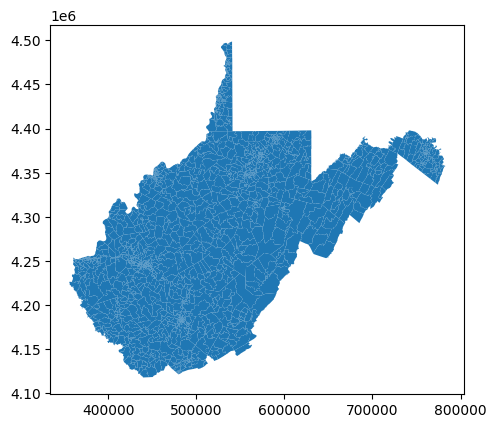

In [67]:
shapefile_path = "./{}/{}.shp".format(state_ab, state_ab)
shape=gpd.read_file(shapefile_path)
shape.plot()